In [1]:
from neural_networks.LSTM_Long_Short_Term_Mermory.LSTM_torch_class import LSTM_torch
from neural_networks.nn_helper_functions import init_weights_LSTM as init_weights
import torch
import torch.nn as nn
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#tensorboard --logdir 'runs\LSTM_pytorch_full' --host localhost --port 8888
from IPython.display import clear_output
clear_output()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

# Read data, remove trend

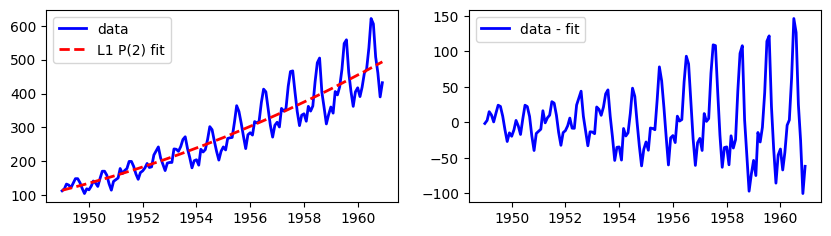

In [3]:
df = pd.read_csv(os.path.join('data_processing','media','airline-passengers.csv'), index_col=0, parse_dates=True)

timeseriesOG  = torch.tensor(df["Passengers"].values, dtype = torch.float)

phi         = torch.ones(len(timeseriesOG), 3)
phi[:,1]    = torch.arange(len(timeseriesOG))
phi[:,2]    = torch.arange(len(timeseriesOG))**2

regr3 = linear_model.Lasso(alpha=0.05, fit_intercept=False).fit(phi, timeseriesOG)  
fit = phi @ regr3.coef_

fig, ax = plt.subplots(1,2, figsize=(10,2.5))
ax = ax.flatten()

ax[0].plot(df.index, timeseriesOG, color='blue', linestyle='-', linewidth=2, label='data')
ax[0].plot(df.index, fit.numpy(), color='red', linestyle='--', linewidth=2, label='L1 P(2) fit')
ax[0].legend()

ax[1].plot(df.index, timeseriesOG-fit.numpy(), color='blue', linestyle='-', linewidth=2, label='data - fit')
ax[1].legend()

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = timeseriesOG.clone()
timeseries -= fit.numpy() 
timeseries = timeseries[None,...].T
timeseries = torch.tensor(scaler.fit_transform(timeseries).T[0]).to(torch.float).to(device)
LEN_DATA = timeseries.size(0);LEN_DATA

144

In [5]:
LOOKBACK = 30
data_slices_train = torch.vstack([timeseries[i:i + LOOKBACK] for i in range(LEN_DATA - LOOKBACK + 1)]).to(device)
NUM_SLICES = data_slices_train.size(0);NUM_SLICES

115

In [6]:
HIDDEN_SIZE = 100
net = LSTM_torch(1,HIDDEN_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = Adam(net.parameters(), lr = 1e-4)#, weight_decay=1e-5)

# Train model
learn to predict 1 step ahead
test by predicting N_FORWARD steps into future

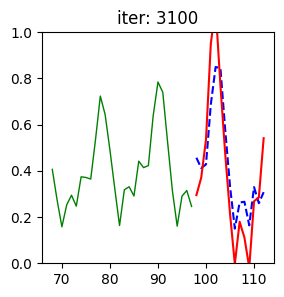

iter: 3100 loss:  0.005808418289879214 test_loss:  tensor(0.0235, device='cuda:0') start:  68


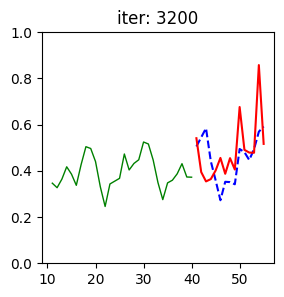

iter: 3200 loss:  0.010257947476965512 test_loss:  tensor(0.0172, device='cuda:0') start:  11


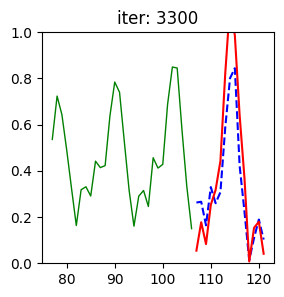

iter: 3300 loss:  0.007837529281097488 test_loss:  tensor(0.0225, device='cuda:0') start:  77


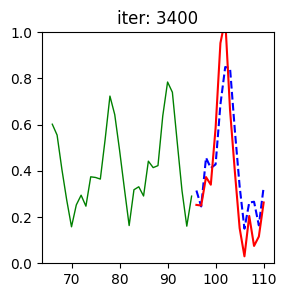

iter: 3400 loss:  0.009125773502895562 test_loss:  tensor(0.0209, device='cuda:0') start:  66


In [7]:
NUM_EPOCHS = 3500

now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_full', s2))
step = 0

N_FORWARD = 15

for i in range(NUM_EPOCHS):
    loss2 = 0
    js = torch.randperm(data_slices_train.size(0) - 1)
    #js = torch.arange(data_slices_train.size(0) - 1)
    #js = torch.arange(data_slices_train.size(0) - 1)  
    for j in js:
        output = net(data_slices_train[j].unsqueeze(0).T)[0][0]
        y = data_slices_train[j+1,-1:]
        loss   = criterion(output, y)
        loss2 += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # test prediction of N steps forward
    if i % 100 == 0:
            with torch.no_grad():

                plt.figure(figsize=(3,3))
                plt.clf()

                random_start = torch.randint(high= NUM_SLICES - N_FORWARD - 5, size = (1,)).item()

                idx_base = range(random_start, random_start + LOOKBACK)
                
                data_buffer  = timeseries[idx_base].unsqueeze(0).T
                data_buffer_old = data_buffer.clone()
                
                idx_pred = range(random_start + LOOKBACK, random_start + LOOKBACK + N_FORWARD)
                y_true = timeseries[idx_pred]

                plt.plot(idx_base, data_buffer.view(-1).cpu().numpy()   , c='green' , lw = 1)
                plt.plot(idx_pred, y_true.cpu().numpy()                 , c='blue'  , ls = '--')

                hs_prev = init_weights((1, HIDDEN_SIZE), HIDDEN_SIZE).to(device)
                cs_prev = init_weights((1, HIDDEN_SIZE), HIDDEN_SIZE).to(device)
                y_pred  = torch.zeros_like(y_true)

                for k in range(N_FORWARD): 
                    output, hs_prev, cs_prev = net.forward(data_buffer, hs_prev, cs_prev)
                    y_pred[k] = output[0]   # save prediction
                    # shift buffer values to left by 1, add predict in the end
                    data_buffer.view(-1)[:-1] = data_buffer_old.view(-1)[1:]
                    data_buffer.view(-1)[-1] = output[0]
                    data_buffer_old = data_buffer.clone()
                    
                loss_test = criterion(y_true,y_pred)
                
                plt.plot(idx_pred, y_pred.cpu().numpy(), c='red')
                plt.ylim(0, 1)
                plt.title(f'iter: {i}')
                plt.show()

                print('iter:',i, f'loss: {loss2:0.4f}', 'test_loss: ', loss_test.item(), 'start: ', random_start)

        
    if i % 501 == 0 and i > 1:
         torch.save(net.state_dict(), os.path.join('neural_networks','save_states','LSTM',f'pytorch_full_{HIDDEN_SIZE}.pht'))
         clear_output()
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1